In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [3]:
#pd.set_option('display.max_columns', None)

Dataset has 1670214 observations and 37 features, no duplicates.

In [2]:
previous_application = help_tool.csv_download(r'Archive\home-credit-default-risk\previous_application.csv')
help_tool.first_look(previous_application)

Dataset has 1670214 observations and 37 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
AMT_ANNUITY,float64,372235,22.3
AMT_APPLICATION,float64,0,0.0
AMT_CREDIT,float64,1,0.0
AMT_DOWN_PAYMENT,float64,895844,53.6
AMT_GOODS_PRICE,float64,385515,23.1
WEEKDAY_APPR_PROCESS_START,object,0,0.0
HOUR_APPR_PROCESS_START,int64,0,0.0


# Null values
Null values can be seen in the same rows for last 5 features.

In [34]:
previous_application[previous_application['DAYS_FIRST_DRAWING'].isna()][previous_application.columns[31:]].notna().sum()

DAYS_FIRST_DRAWING           0
DAYS_FIRST_DUE               0
DAYS_LAST_DUE_1ST_VERSION    0
DAYS_LAST_DUE                0
DAYS_TERMINATION             0
NFLAG_INSURED_ON_APPROVAL    0
dtype: int64

Similarly, AMT_DOWN_PAYMENT is empty when RATE_DOWN_PAYMENT is empty.

In [35]:
previous_application[previous_application['AMT_DOWN_PAYMENT'].isna()]['RATE_DOWN_PAYMENT'].notna().sum()

0

Null values will not be handeleed after Feature selection.

# Object features

In [36]:
previous_application = help_tool.convert_flags(previous_application)

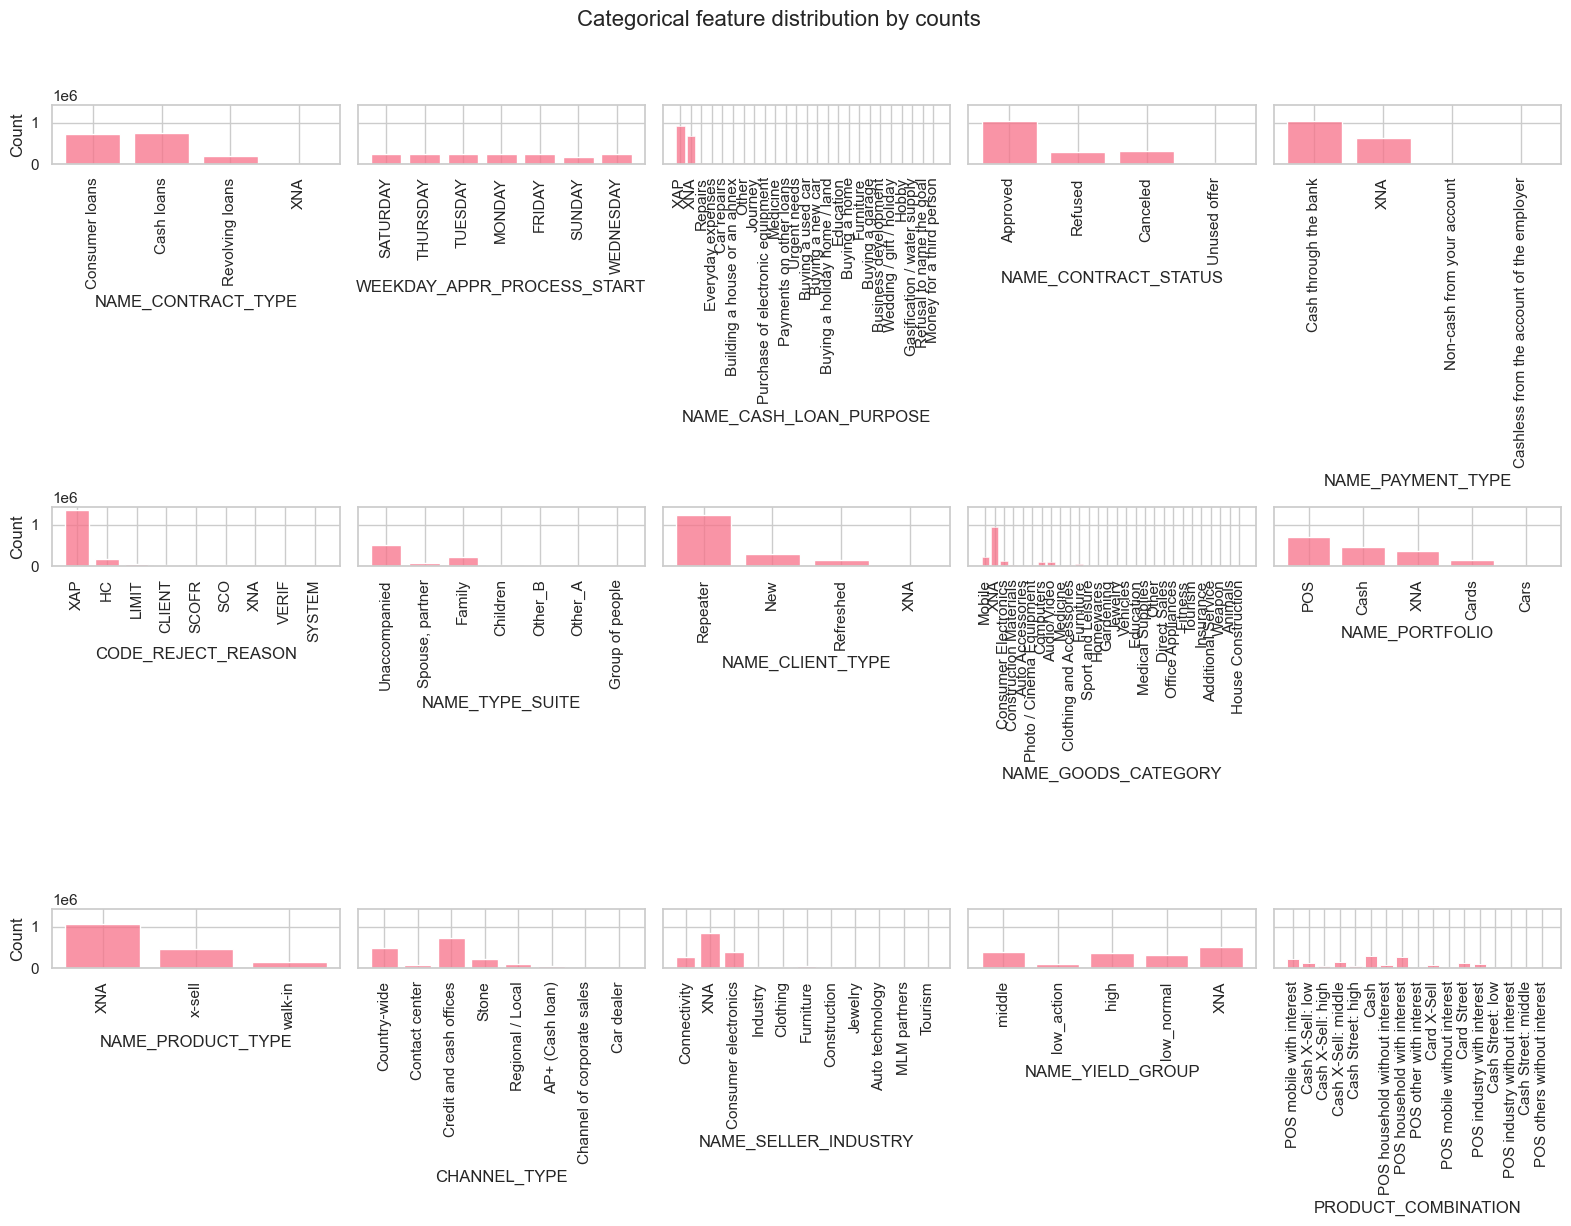

In [37]:
object_columns = previous_application.select_dtypes(include=['object']).columns.tolist()



fig, axes = plt.subplots(3, 5, figsize=(16, 12), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.histplot(data=previous_application, x=col, bins=20, multiple="dodge", shrink=.8,
                 ax=axes[i], legend=True)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

### NAME_CASH_LOAN_PURPOSE
90% of Cash loans responded with XNA (unknown), while Consumer loans and Revolving loans have subvalues XAP (Application Error). NAME_CASH_LOAN_PURPOSE will be dropped.

In [39]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_CASH_LOAN_PURPOSE']].value_counts() / previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_CASH_LOAN_PURPOSE          
Cash loans          XNA                                  90.684941
                    Repairs                               3.179039
                    Other                                 2.087879
                    Urgent needs                          1.125271
                    Buying a used car                     0.386327
                    Building a house or an annex          0.360242
                    Everyday expenses                     0.323188
                    Medicine                              0.290816
                    Payments on other loans               0.258309
                    Education                             0.210420
                    Journey                               0.165741
                    Purchase of electronic equipment      0.141930
                    Buying a new car                      0.135375
                    Wedding / gift / holiday              0.128687
         

In [40]:
previous_application.drop(columns='NAME_CASH_LOAN_PURPOSE', inplace=True)

### NAME_PAYMENT_TYPE 
Has useful values and will be left

In [41]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_PAYMENT_TYPE']].value_counts() / previous_application[['NAME_PAYMENT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_PAYMENT_TYPE                        
Consumer loans      Cash through the bank                        61.100167
Cash loans          Cash through the bank                        38.899833
Consumer loans      Cashless from the account of the employer    65.345622
Cash loans          Cashless from the account of the employer    34.654378
Consumer loans      Non-cash from your account                   77.932381
Cash loans          Non-cash from your account                   22.067619
                    XNA                                          54.722307
Revolving loans     XNA                                          30.788799
Consumer loans      XNA                                          14.433744
XNA                 XNA                                           0.055150
Name: count, dtype: float64

### NAME_PORTFOLIO
NAME_PORTFOLIO has XNA values, but the information is dublicated by PRODUCT_COMBINATION

In [42]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_PORTFOLIO', 'PRODUCT_COMBINATION']].drop_duplicates().sort_values(by='NAME_CONTRACT_TYPE')

,NAME_CONTRACT_TYPE,NAME_PORTFOLIO,PRODUCT_COMBINATION
1,Cash loans,Cash,Cash X-Sell: low
2,Cash loans,Cash,Cash X-Sell: high
3,Cash loans,Cash,Cash X-Sell: middle
4,Cash loans,Cash,Cash Street: high
6,Cash loans,XNA,Cash
228,Cash loans,Cash,Cash Street: middle
85,Cash loans,Cash,Cash Street: low
0,Consumer loans,POS,POS mobile with interest
4997,Consumer loans,XNA,POS other with interest
2567,Consumer loans,XNA,POS industry with interest


Product combination was sorted to other features

In [43]:
previous_application.drop(columns='NAME_PORTFOLIO', inplace=True)

### 

In [44]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY']].value_counts() / previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_GOODS_CATEGORY     
Cash loans          XNA                         100.000000
Consumer loans      Mobile                       30.814742
                    Consumer Electronics         16.627146
                    Computers                    14.502894
                    Audio/Video                  13.626396
                    Furniture                     7.356501
                    Photo / Cinema Equipment      3.431114
                    Construction Materials        3.427959
                    Clothing and Accessories      3.230332
                    XNA                           1.403276
                    Auto Accessories              1.012273
                    Jewelry                       0.862647
                    Homewares                     0.688883
                    Medical Supplies              0.527051
                    Vehicles                      0.462181
                    Sport and Leisure             0.408832
           

In [45]:
top_goods_list = previous_application['NAME_GOODS_CATEGORY'].value_counts().nlargest(5).index.to_list()

previous_application.loc[~previous_application['NAME_GOODS_CATEGORY'].isin(top_goods_list), 'NAME_GOODS_CATEGORY'] = 'Other'

In [46]:
previous_application[['NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY']].value_counts() / previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

NAME_CONTRACT_TYPE  NAME_GOODS_CATEGORY 
Cash loans          XNA                     100.000000
Consumer loans      Mobile                   30.814742
                    Other                    23.025546
                    Consumer Electronics     16.627146
                    Computers                14.502894
                    Audio/Video              13.626396
                    XNA                       1.403276
Revolving loans     XNA                      99.748400
                    Consumer Electronics      0.175499
                    Audio/Video               0.043486
                    Mobile                    0.011389
                    Computers                 0.010872
                    Other                     0.010354
XNA                 XNA                     100.000000
Name: count, dtype: float64

In [47]:
previous_application = help_tool.product_combination(previous_application)

previous_application['NAME_CLIENT_TYPE'] = help_tool.client_type_encoding(previous_application, 'NAME_CLIENT_TYPE')
previous_application = help_tool.weekday_encoding(previous_application)

In [48]:
previous_application['NAME_TYPE_SUITE'] = help_tool.accompanied(previous_application, 'NAME_TYPE_SUITE')

In [49]:
previous_application['YIELD_GROUP'] = previous_application['NAME_YIELD_GROUP'].apply(lambda x: 1 if 'low_normal' in x.lower() else 1.5 if 'low_action' in x.lower() else 2 if 'middle' in x.lower() else 3 if 'high' in x.lower() else np.nan)
previous_application.drop(columns='NAME_YIELD_GROUP', inplace=True)

In [ ]:
# previous_application[[
#     #'NAME_CONTRACT_TYPE', 
#     #'NAME_PRODUCT_TYPE', 
#     #'PRODUCT_COMBINATION', 
#     'NAME_SELLER_INDUSTRY'
#                       ]].value_counts() #/ previous_application[['NAME_CONTRACT_TYPE']].value_counts() * 100

In [50]:
previous_application.select_dtypes(include=['object']).columns.tolist()

['NAME_CONTRACT_TYPE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_GOODS_CATEGORY',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'PRODUCT_PLACE']

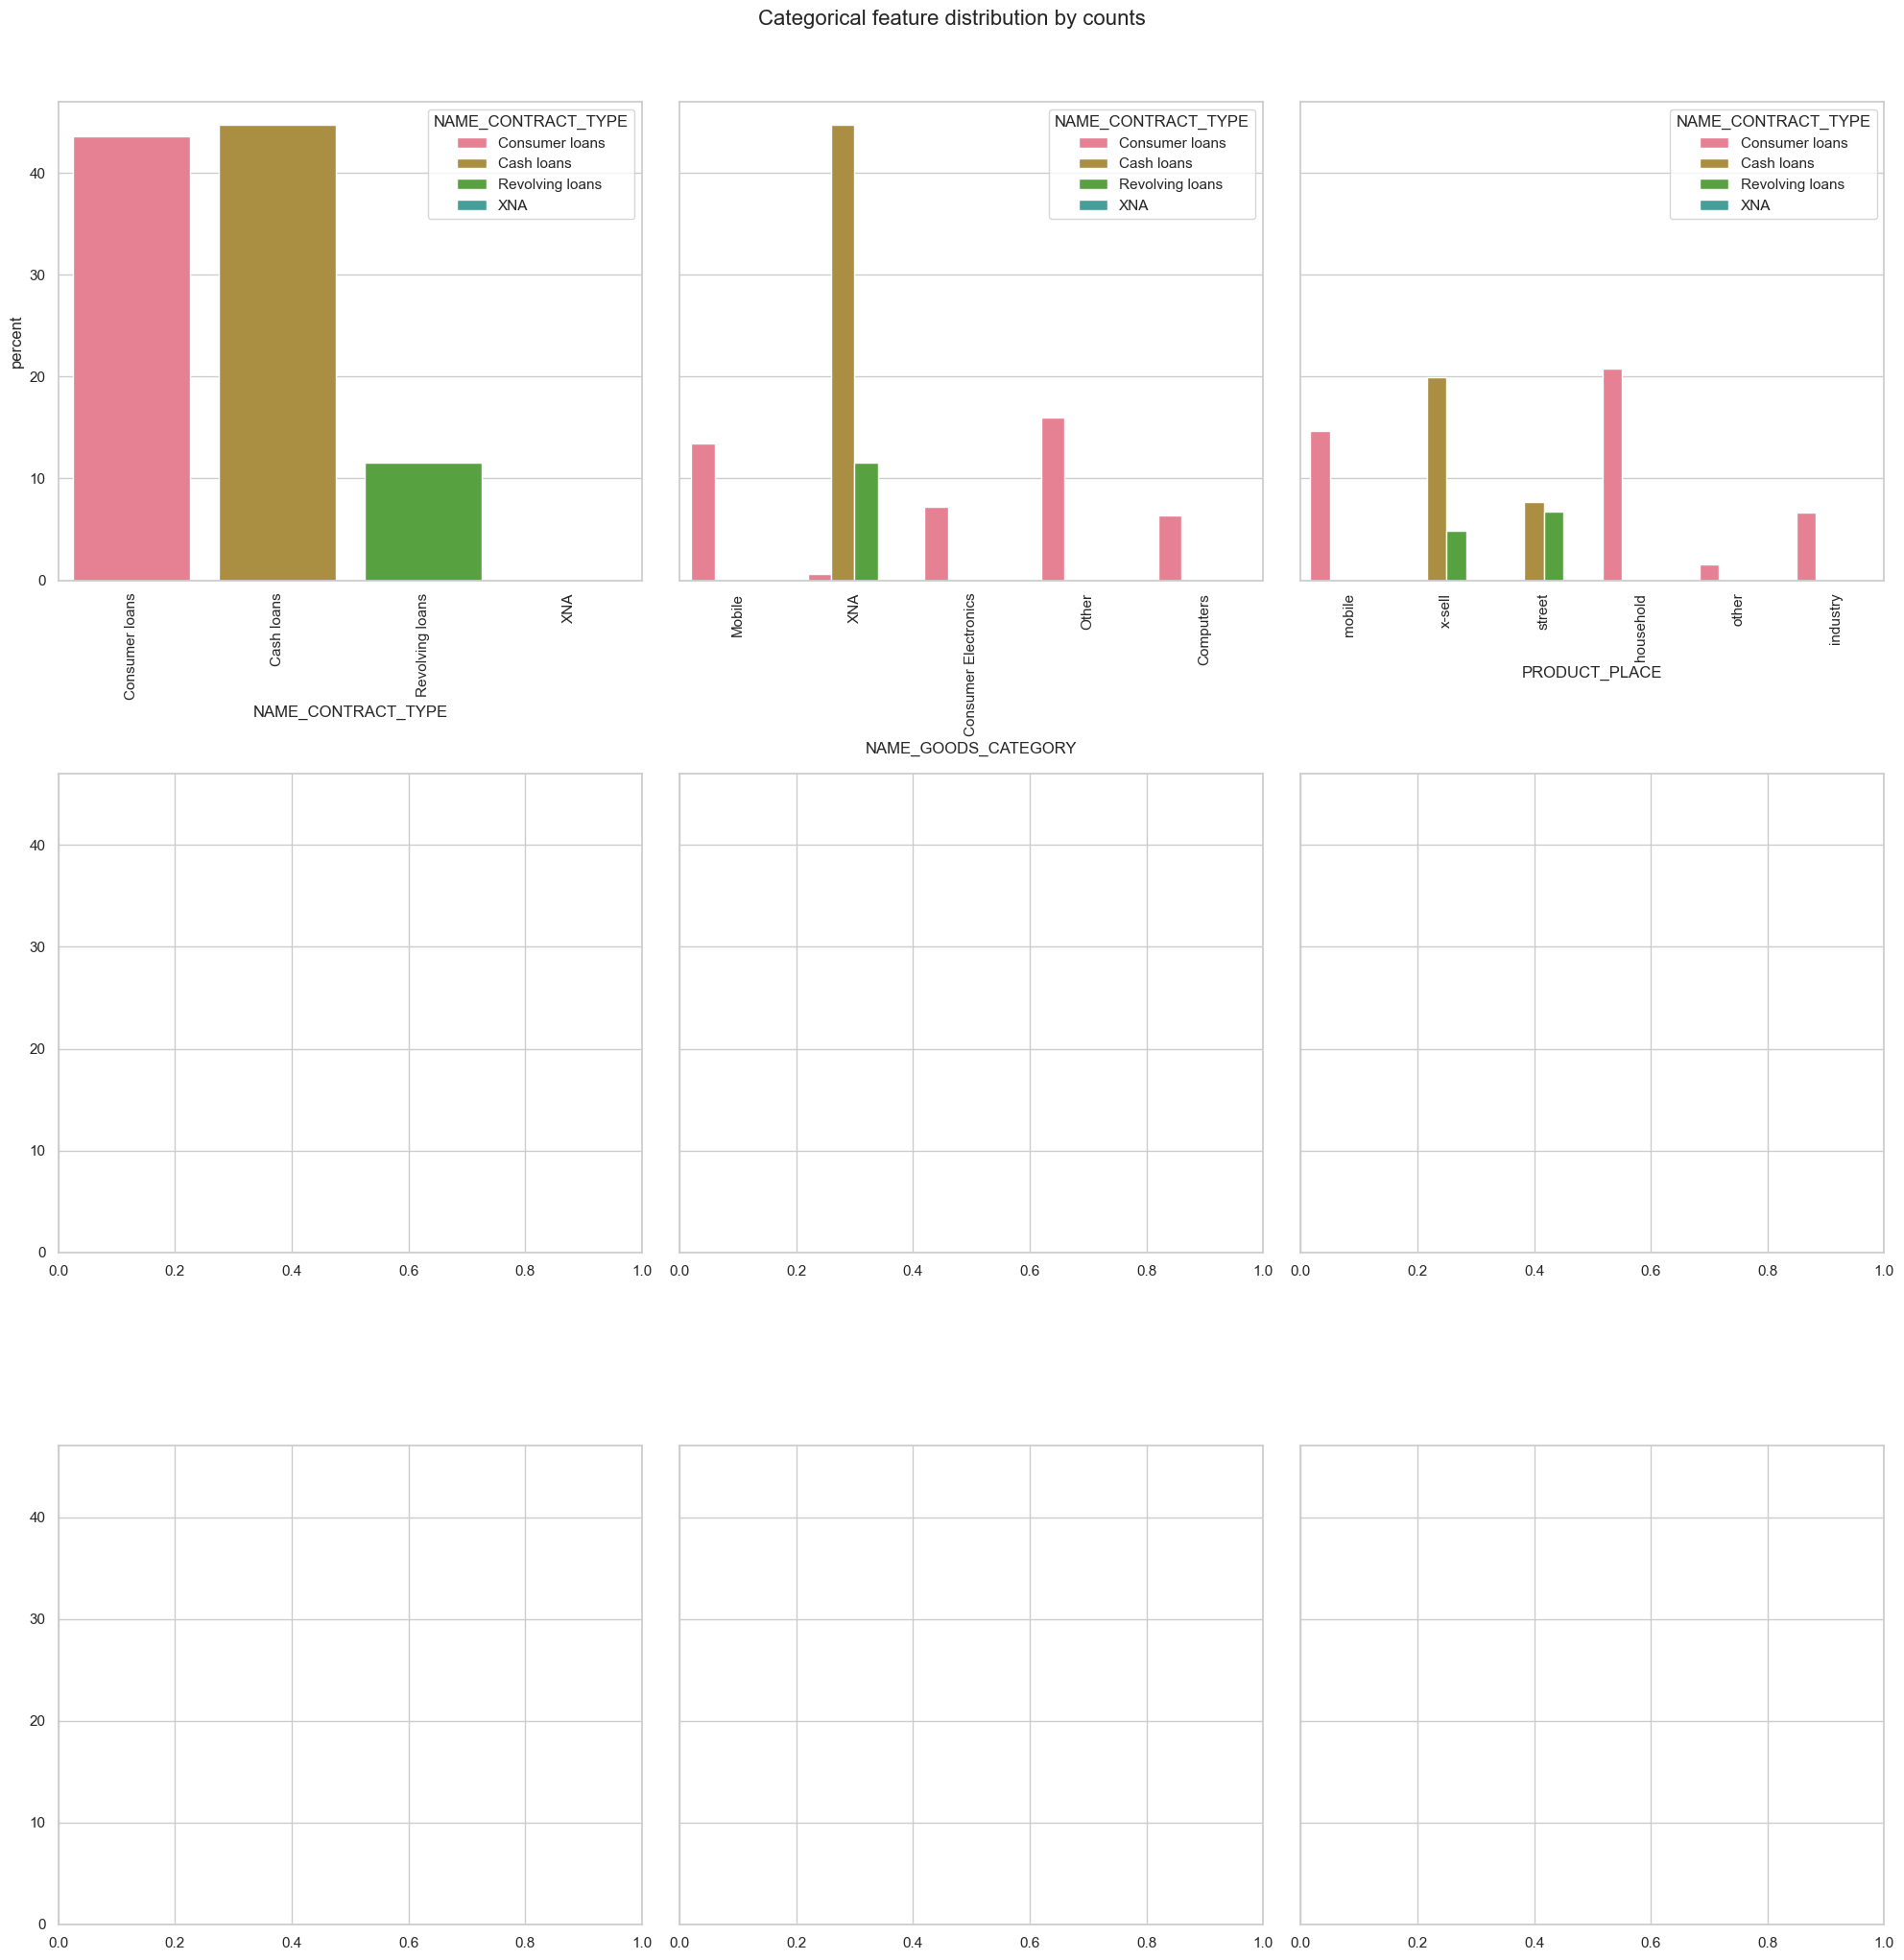

In [33]:
object_columns = previous_application.select_dtypes(include=['object']).columns.tolist()

fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.countplot(data=previous_application, x=col, 
                 ax=axes[i],  
                 legend=True,
                 stat="percent",
                 hue='NAME_CONTRACT_TYPE'
                 )
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

* NAME_PAYMENT_TYPE values are either 'Cash through the bank' or XNA, values will be assigned to 1/0 for known Payment Types on 'Cash through the bank'.
* NAME_PORTFOLIO has XNA values, but the information is dublicated by PRODUCT_COMBINATION. Apart from NAME_PORTFOLIO, which take up < 1% of 'Consumer loans'.
* 90% of Cash loans responded with XNA (unknown), while Consumer loans and Revolving loans have subvalues XAP (Application Error). NAME_CASH_LOAN_PURPOSE will be dropped.


In [30]:
previous_application['CONTRACT_STATUS'] = help_tool.contract_status(previous_application, 'NAME_CONTRACT_STATUS')

In [28]:
previous_application['NAME_GOODS_CATEGORY'] = help_tool.top_five_categories(previous_application, 'NAME_GOODS_CATEGORY')

In [26]:
previous_application['PAYMENT_TYPE_Cash_through_the_bank'] = help_tool.payment_type(previous_application, 'NAME_PAYMENT_TYPE')

In [32]:
previous_application.drop(columns=['CODE_REJECT_REASON', 'CHANNEL_TYPE', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY'], inplace=True)

In [35]:
previous_application[['NAME_GOODS_CATEGORY', 'PRODUCT_PLACE']].value_counts()

NAME_GOODS_CATEGORY   PRODUCT_PLACE
XNA                   x-sell           414014
                      street           240227
Mobile                mobile           205219
Other                 household        117698
Consumer Electronics  household        117357
Other                 industry         107643
Computers             household         87997
Other                 other             23275
Mobile                household         18674
Other                 mobile            18632
Computers             mobile            17147
XNA                   household          4804
                      mobile             3266
Consumer Electronics  industry           2174
                      other              1218
XNA                   industry           1092
                      other              1070
Consumer Electronics  mobile              488
Mobile                other               476
Computers             other               395
Consumer Electronics  street              33

# Target - exploring useful features

In [18]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')
application_train = help_tool.convert_flags(application_train)
application_train = help_tool.encode_categories(application_train)

In [19]:
application_train.drop(columns=['APARTMENTS_AVG', 'APARTMENTS_MODE'], inplace=True)
application_train.drop(columns=application_train.filter(like='_AVG').columns.str.replace('AVG', 'MODE').to_list(), inplace=True)
application_train.drop(columns=application_train.filter(like='_AVG').columns, inplace=True)

application_train.drop(columns=["LIVINGAPARTMENTS_MEDI", "LIVINGAREA_MEDI", "APARTMENTS_MEDI"], inplace=True)

In [20]:
all_applications = duckdb.query("""
            WITH 
             current_app AS (SELECT SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE FROM application_train)

             ,previous_app AS (SELECT * FROM previous_application)

             SELECT A.*, B.NAME_CONTRACT_TYPE, B.TARGET
             FROM previous_app A
             INNER JOIN current_app B
             ON A.SK_ID_CURR = B.SK_ID_CURR
             """).to_df()

all_applications.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(1413701, 43)

In [21]:
all_applications[['NAME_CONTRACT_TYPE', 'NAME_CONTRACT_TYPE_1']].drop_duplicates()

,NAME_CONTRACT_TYPE,NAME_CONTRACT_TYPE_1
0,Consumer loans,Consumer loans
4096,Cash loans,Cash loans
8399,Revolving loans,Revolving loans
36153,XNA,XNA


In [22]:
all_applications.drop(columns='NAME_CONTRACT_TYPE_1', inplace=True)

## NAME_CONTRACT_TYPE = Cash loans

In [23]:
cash_loans = all_applications[all_applications['NAME_CONTRACT_TYPE'] == 'Cash loans'].drop(columns=['SK_ID_PREV', 'SK_ID_CURR'])

Cash Loans have distinct constants: 
* NAME_GOODS_CATEGORY is XNA
* AMT_DOWN_PAYMENT, RATE_DOWN_PAYMENT, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED  is Null or 0 for Cash Loans

In [24]:
cash_loans[cash_loans.columns[cash_loans.nunique() == 1].to_list() + cash_loans.columns[cash_loans.isna().all()].to_list()].drop_duplicates()

,NAME_CONTRACT_TYPE,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,NAME_GOODS_CATEGORY,Mobile,Industry,Household,Without_interest,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED
4096,Cash loans,NaN,NaN,XNA,0,0,0,0,NaN,NaN
4119,Cash loans,0.0,0.0,XNA,0,0,0,0,NaN,NaN


In [25]:
cash_loans.dropna(axis=1, how='all', inplace=True)
cash_loans.drop(columns=cash_loans.columns[cash_loans.nunique() == 1], inplace=True)

9% of Cash loans have defaulted

In [26]:
cash_loans['TARGET'].value_counts() /cash_loans['TARGET'].count() * 100

TARGET
0    90.874237
1     9.125763
Name: count, dtype: float64

In [27]:
cash_loans.shape

(626764, 30)

In [28]:
#cash_loans_dummies = help_tool.dummy_columns(cash_loans, cash_loans.select_dtypes(include=['object']).columns.tolist())

## Numerical features are not correlated with TARGET

In [29]:
numeric_features = cash_loans.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()
target_correlations = correlation_matrix['TARGET'].sort_values(ascending=False)

target_correlations

TARGET                         1.000000
CNT_PAYMENT                    0.057412
NEW_RANK                       0.055271
YIELD_GROUP                    0.053528
DAYS_LAST_DUE_1ST_VERSION      0.046822
DAYS_DECISION                  0.033145
Street                         0.031741
NFLAG_INSURED_ON_APPROVAL      0.008510
DAYS_FIRST_DUE                 0.004394
DAYS_FIRST_DRAWING             0.001153
SELLERPLACE_AREA               0.000765
NFLAG_LAST_APPL_IN_DAY        -0.001027
WEEKDAY_APPR_PROCESS_START    -0.001444
DAYS_LAST_DUE                 -0.002081
DAYS_TERMINATION              -0.002767
FLAG_LAST_APPL_PER_CONTRACT   -0.007972
AMT_CREDIT                    -0.008149
AMT_GOODS_PRICE               -0.009102
NAME_CLIENT_TYPE              -0.009408
AMT_APPLICATION               -0.011574
NAME_TYPE_SUITE               -0.017918
HOUR_APPR_PROCESS_START       -0.021114
AMT_ANNUITY                   -0.026305
X_Sell                        -0.035168
Name: TARGET, dtype: float64

In [30]:
cash_loans.select_dtypes(include=['object']).columns.tolist()

['NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY']

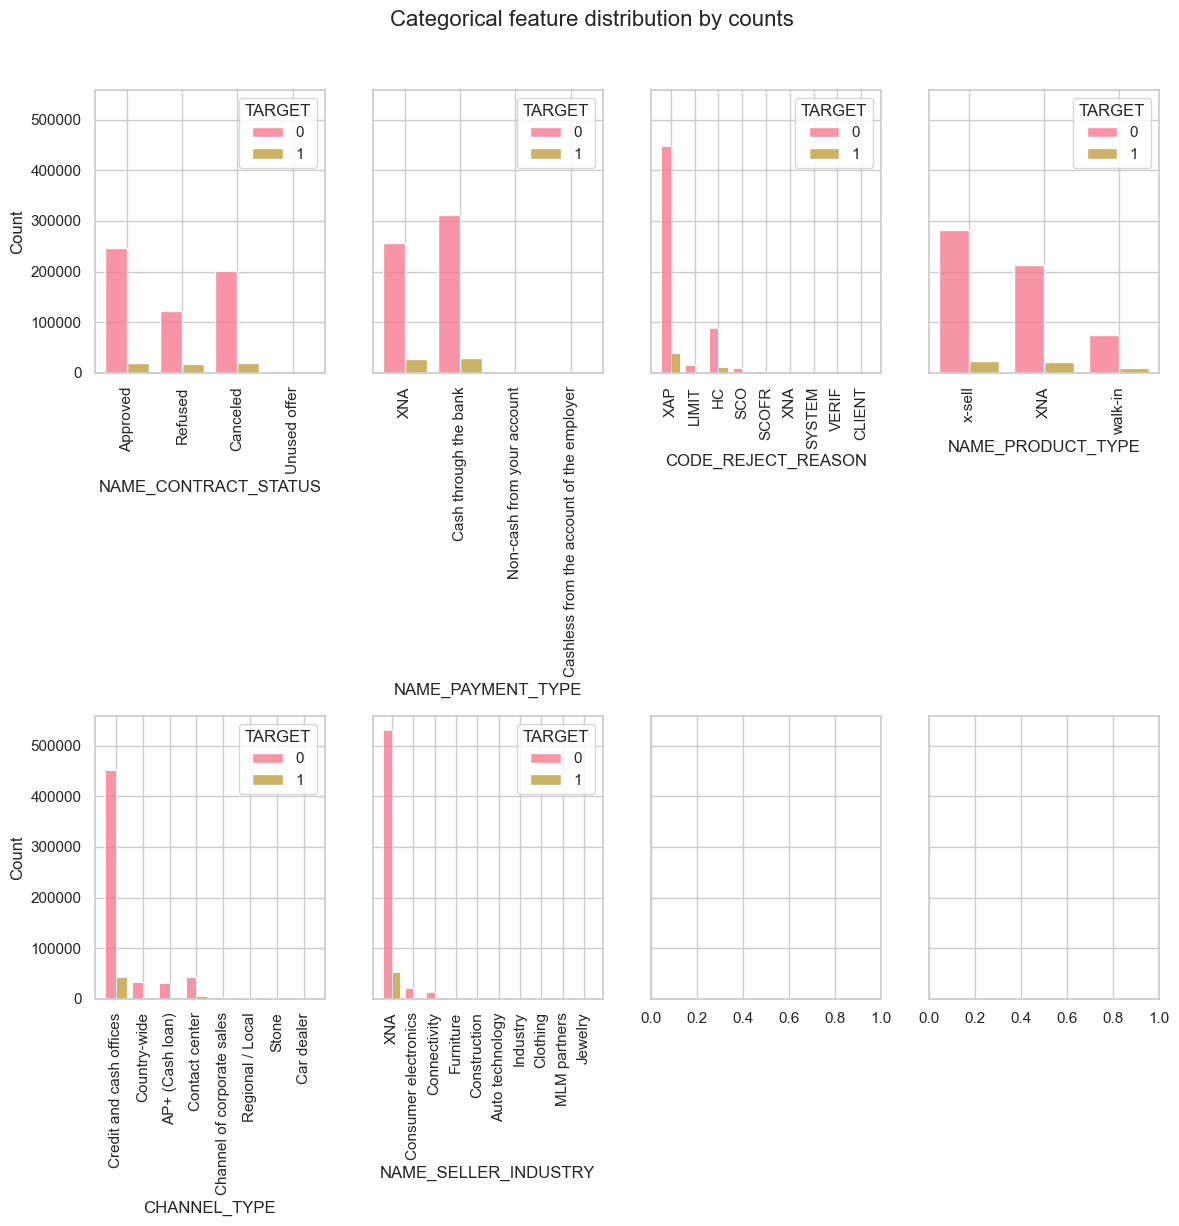

In [31]:
object_columns = cash_loans.select_dtypes(include=['object']).columns.tolist()



fig, axes = plt.subplots(2, 4, figsize=(12, 12), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.histplot(data=cash_loans, x=col, bins=20, multiple="dodge", shrink=.8,
                 ax=axes[i], hue='TARGET',
                 legend=True)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

In [65]:
cash_loans.describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,YIELD_GROUP,TARGET
count,391663.000000,6.267640e+05,6.267640e+05,3.934140e+05,626764.000000,626764.000000,626764.000000,626764.000000,626764.000000,626764.000000,625767.000000,626764.000000,391663.000000,246173.000000,246173.000000,246173.000000,246173.000000,246173.000000,246173.000000,391663.000000,626764.000000
mean,26048.663922,2.780538e+05,3.076521e+05,4.429790e+05,0.139491,11.981130,0.999994,0.999430,-561.372793,0.347590,1.933923,13.032540,28.392059,365237.028464,-175.857511,-139.673555,90163.911424,91518.134592,0.800181,1.931488,0.091258
std,17778.280892,3.960914e+05,4.313457e+05,4.205794e+05,0.669479,3.230603,0.002526,0.023859,557.717087,0.476205,0.208690,239.791747,16.794926,1481.404449,15562.199659,822.909334,158077.908416,158855.819681,0.399865,0.758056,0.287975
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-0.974928,0.000000,0.000000,0.000000,-2922.000000,0.000000,1.000000,-1.000000,3.000000,-2328.000000,-2892.000000,-2739.000000,-2883.000000,-2828.000000,0.000000,1.000000,0.000000
25%,13608.000000,0.000000e+00,0.000000e+00,1.350000e+05,-0.433884,10.000000,1.000000,1.000000,-737.000000,0.000000,2.000000,-1.000000,12.000000,365243.000000,-1044.000000,-527.000000,-743.000000,-736.000000,1.000000,1.000000,0.000000
50%,21699.720000,1.350000e+05,1.439100e+05,2.700000e+05,0.000000,12.000000,1.000000,1.000000,-357.000000,0.000000,2.000000,-1.000000,24.000000,365243.000000,-691.000000,-60.000000,-330.000000,-323.000000,1.000000,2.000000,0.000000
75%,33490.485000,4.050000e+05,4.500000e+05,6.075000e+05,0.781831,14.000000,1.000000,1.000000,-203.000000,1.000000,2.000000,-1.000000,36.000000,365243.000000,-419.000000,362.000000,-6.000000,365243.000000,1.000000,3.000000,0.000000
max,418058.145000,4.050000e+06,4.104351e+06,4.050000e+06,0.974928,23.000000,1.000000,1.000000,-2.000000,1.000000,2.000000,30200.000000,84.000000,365243.000000,365243.000000,2389.000000,365243.000000,365243.000000,1.000000,3.000000,1.000000


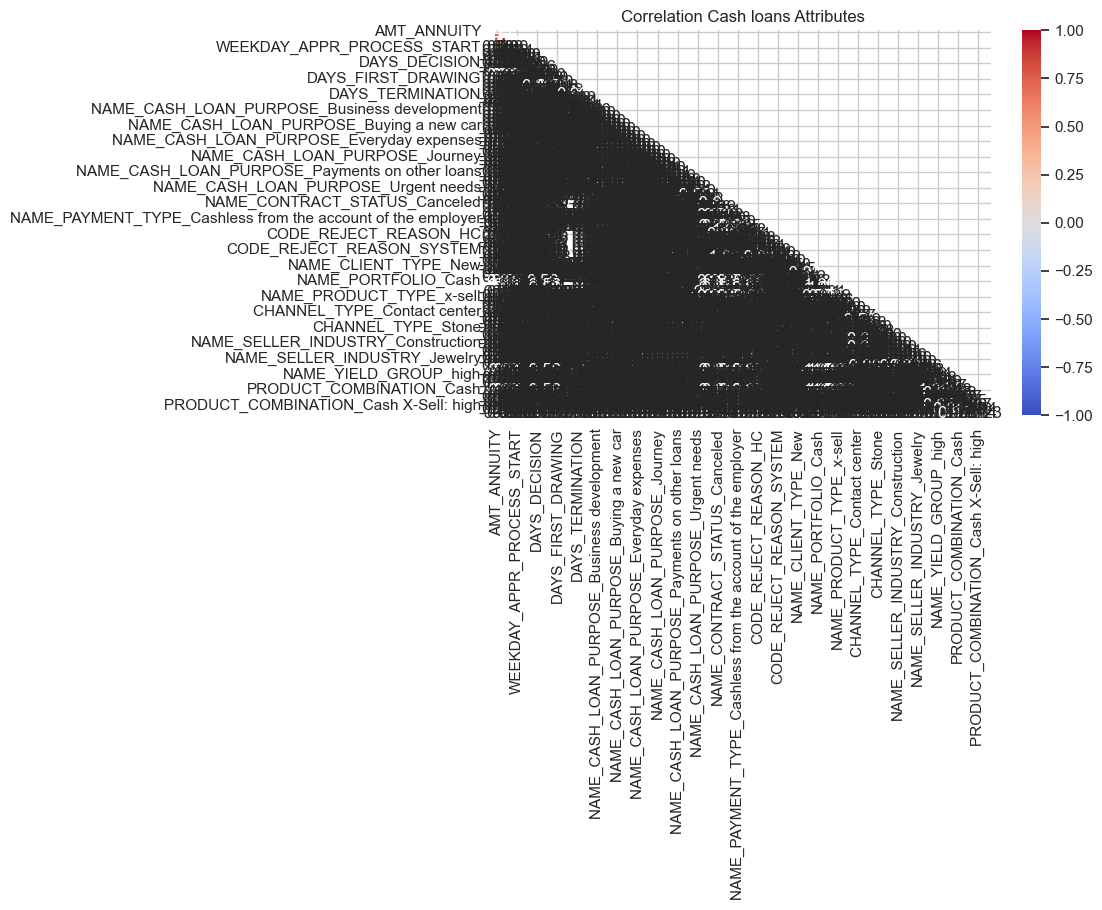

In [52]:
help_visuals.heatmap(cash_loans_dummies, 'Cash Loans', 'pearson')

In [34]:
cash_loans_dummies.corr()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,NAME_TYPE_SUITE,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle
AMT_ANNUITY,1.000000,0.772139,0.762887,NaN,0.772139,0.000755,0.067573,0.000908,-0.003003,NaN,NaN,NaN,0.214996,-0.044447,-0.002658,0.169992,0.003330,0.001214,0.229925,0.069746,0.071328,-0.011479,-0.026305,0.049275,0.027324,0.007403,0.030215,0.041002,0.050597,0.032911,-0.010570,-0.026308,-0.033724,-0.005880,-0.005945,0.000902,-0.006242,-0.029736,-0.002351,-0.020329,0.017670,-0.023380,-0.002383,0.005082,-0.040581,-0.008558,0.008637,-0.075069,0.044410,0.062607,NaN,0.022906,-0.003657,-0.011238,-0.020839,NaN,0.058123,0.017648,-0.031547,-0.004758,0.002745,0.082700,-0.062607,0.008594,-0.025322,-0.010689,0.024001,0.003840,NaN,NaN,NaN,NaN,-0.005570,0.005570,-0.058354,0.001308,0.021625,0.063517,-0.174173,0.110700,-0.012628,-0.011059,-0.003254,0.000763,-0.100778,-0.000674,-0.131737,0.007712,-0.002567,0.000479,-0.001044,0.165559,NaN,-0.195828,0.209297,0.169375,-0.077488,NaN,-0.188996,0.121120,-0.008233,-0.065795,0.204899,-0.076956
AMT_APPLI

# Unused offer + Canceled  (NAME_CONTRACT_STATUS)

In [20]:
previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Canceled']['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         268591
Revolving loans     45854
Consumer loans       1559
XNA                   315
Name: count, dtype: int64

In [21]:
previous_application[['NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON']].value_counts().reset_index(name='count').sort_values(by=['NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON'])

,NAME_CONTRACT_STATUS,CODE_REJECT_REASON,count
0,Approved,XAP,1036773
10,Approved,XNA,8
1,Canceled,XAP,316319
2,Refused,HC,175231
3,Refused,LIMIT,55680
4,Refused,SCO,37467
6,Refused,SCOFR,12811
9,Refused,SYSTEM,717
8,Refused,VERIF,3535
11,Refused,XAP,1


In [22]:
previous_application.loc[previous_application['NAME_CONTRACT_STATUS'] == 'Approved', 'CODE_REJECT_REASON'] = 'Approved'
previous_application.loc[previous_application['NAME_CONTRACT_STATUS'] == 'Unused offer', 'CODE_REJECT_REASON'] = 'Unused offer'

In [23]:
previous_application['NAME_CONTRACT_STATUS'].value_counts() / 1036781 * 100

NAME_CONTRACT_STATUS
Approved        100.000000
Canceled         30.509722
Refused          28.036586
Unused offer      2.549815
Name: count, dtype: float64

In [24]:
previous_application_canceled = previous_application.copy()
previous_application_canceled.drop(columns=['CODE_REJECT_REASON', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'], inplace=True)
previous_application_canceled.drop(columns=['SK_ID_PREV', 'SK_ID_CURR'], inplace=True)

In [25]:
previous_application_canceled['Canceled_Unused'] = 0
previous_application_canceled.loc[previous_application_canceled['NAME_CONTRACT_STATUS'].isin(['Canceled', 'Unused offer']), 'Canceled_Unused'] = 1

previous_application_canceled.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)

In [26]:
previous_application_canceled['Canceled_Unused'].value_counts() / previous_application_canceled['Canceled_Unused'].value_counts().max() * 100

Canceled_Unused
0    100.000000
1     25.820383
Name: count, dtype: float64

In [27]:
y = previous_application_canceled['Canceled_Unused']
X = previous_application_canceled.drop(columns=['Canceled_Unused'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Define the model
model = LGBMClassifier(**params, n_estimators=100)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [29]:
# # Evaluate the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision}")
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.8932933419801125
accuracy: 0.9693422703065174
recall: 0.9657761353179183
ROC AUC: 0.9897077086810524


In [30]:
# Extract the preprocessing step and get feature names
preprocessor.fit(X_train)
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = numerical_features + onehot_columns.tolist()

# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Combine feature names and their importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': all_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                    Feature  Importance
10                            DAYS_DECISION         757
13                              Accompanied         200
4                           AMT_GOODS_PRICE         154
92     CHANNEL_TYPE_Credit and cash offices         152
12                              CNT_PAYMENT         113
..                                      ...         ...
53          NAME_GOODS_CATEGORY_Audio/Video           0
52              NAME_GOODS_CATEGORY_Animals           0
51   NAME_GOODS_CATEGORY_Additional Service           0
50                     NAME_CLIENT_TYPE_XNA           0
128                 PRODUCT_COMBINATION_nan           0

[129 rows x 2 columns]


In [31]:
feature_importance_df.head(20)

,Feature,Importance
10,DAYS_DECISION,757
13,Accompanied,200
4,AMT_GOODS_PRICE,154
92,CHANNEL_TYPE_Credit and cash offices,152
12,CNT_PAYMENT,113
90,CHANNEL_TYPE_Contact center,107
11,SELLERPLACE_AREA,100
42,NAME_CASH_LOAN_PURPOSE_XNA,94
49,NAME_CLIENT_TYPE_Repeater,87
3,AMT_DOWN_PAYMENT,86


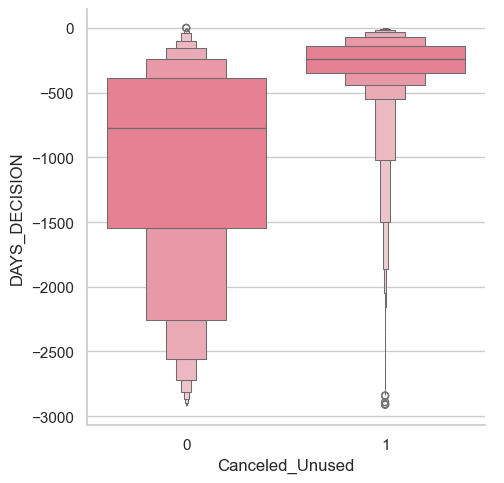

In [32]:
sns.catplot(previous_application_canceled[['DAYS_DECISION', 'Canceled_Unused']], x='Canceled_Unused', y='DAYS_DECISION', kind="boxen")
plt.show()